# **Lab 4. Multiclass classification**

Here we will build a 3-classes classifier by using the *iris flower* dataset.

This is a multivariate dataset introduced by Ronald Fisher in 1936 as an example of discriminant analysis. The dataset consists of 50 samples for each of the three species of iris considered (iris setosa, iris virginica and iris versicolor). For each sample of each species, four features were measured (in cm): the length and the width of the sepals and the petals.

## **1. Preparing and exploring the dataset**
As usal, let's start by setupping the necessary libraries and utilities.

In [205]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc,roc_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
from itertools import cycle

%matplotlib inline

### **1.1. Importing the dataset**
To import the dataset we use the `load_iris()` function from `sklearn`. Then we extract the features matrix `X` and the target vector `y` from the `iris` object.

In [206]:
from sklearn.datasets import load_iris

# Loading the dataset
iris = load_iris()

# Features matrix 
X = iris.data

# Target vector
y = iris.target


Then we create a dataframe `df` by concatenating the features matrix and the target vector using `DataFrame()` from `pandas` library, also specifying the column names.

In [207]:
# Creating a dataframe
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']], columns= iris['feature_names'] + ['target'])

### **1.2. Dataset exploration**
Python allows us to intuitively visualize the structure of the dataframe using the `head()` function, which displays a snapshot of what's inside the dataset. The output of the `head()` function shows the first five rows of the dataset, along with the column names.

### **1.2. Dataset exploration**
Python allows us to intuitively visualize the structure of the dataframe using the `head()` function, which displays a snapshot of what's inside the dataset. The output of the `head()` function shows the first five rows of the dataset, along with the column names.

In [208]:
# Snapshot of the dataset
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


Another way to explore the dataset is by using the `shape` property, which displays the number of rows and columns of the dataframe.

In [209]:
# Shape of the dataset
df.shape

(150, 5)

Yet another interesting way is to use `pairplot()` from `seaborn` to display a pairwise scatterplot matrix of the features contained in the dataframe. In this way we can provide some insights on the distribution of the features and the relationship between them for the different target classes. We can also identify potential patterns of clusters based on how the features divided into the three classes. By setting the `hue` parameter to `target` we have data points with different colours based on the values of the target variable.

[]

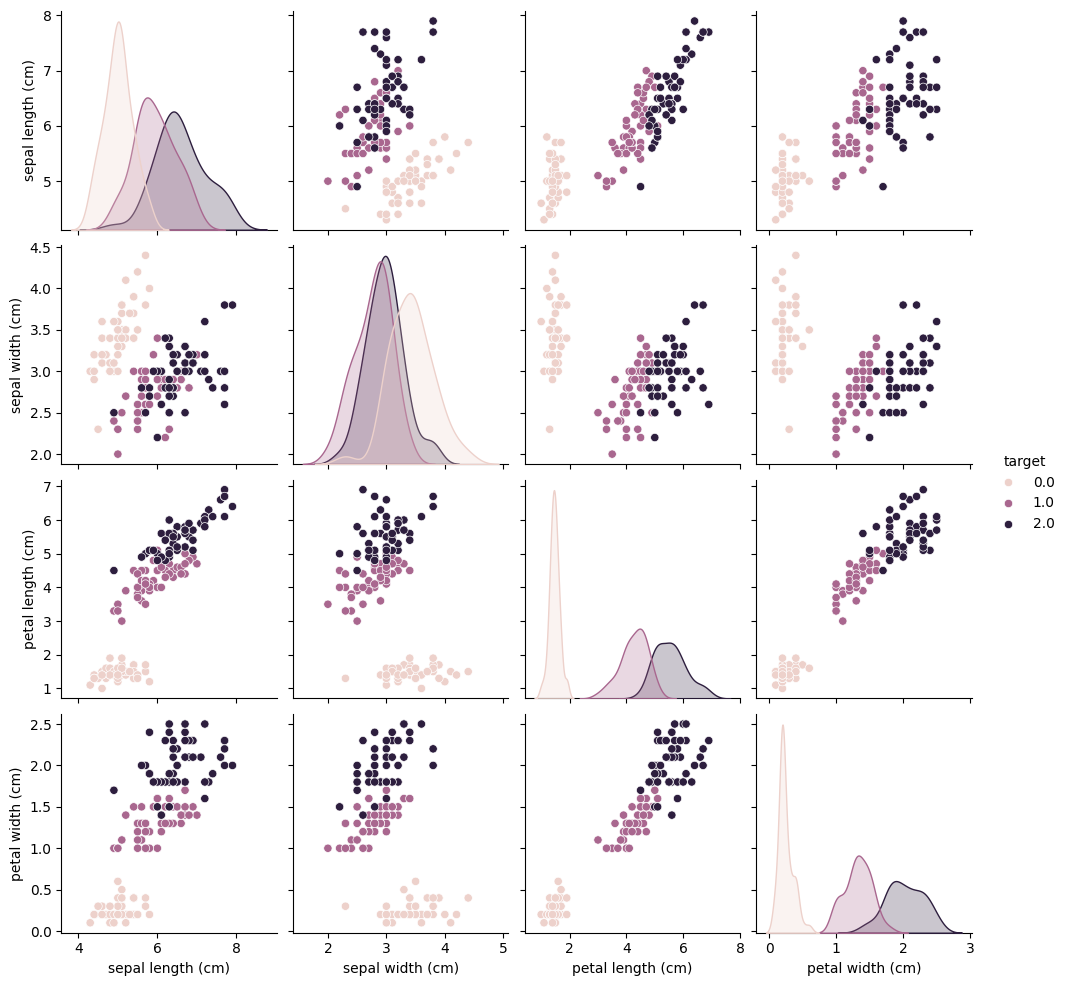

In [210]:
# Pairwise scatterplot
sns.pairplot(df, hue = 'target')
plt.plot()

Along the principal diagonal we have the distribution of the features, while in the rest of the elements we have the correlation between each couple of features.

### **1.3. Splitting data**
Once the dataset has been explored, visualized and well-understood, we need to split our data.

In our pipeline, there is a training phase during which we build our model and a test phase to test if the trained model performs well on completely independent examples, different from the ones used during training. This independent test helps us evaluate the model's generalization error.

For our purposes, we can use the `train_test_split()` function from `sklearn`. In particular, we set the `stratify` parameter to `y` (note that this represents *yes* and not the target vector) because we are interested in ensuring that the class distribution is preserved in both the training set and the test set. Then we also specify `test_size` in order to use the 25% of the entire dataset for the test set. Finally, we specify a `random_state` for the sake of reproducibility.

In [211]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state=1)

To ensure that our dataset has been split correctly, we can assess the `shape` property of both the training and the test set.

In [212]:
print(X_train.shape)
print(X_test.shape)

(112, 4)
(38, 4)


### **1.4. Normalizing data**
Now we can perform the min-max normalization by declaring an instance `scaler` of the `MinMaxScaler()` class from `sklearn` which will be used to scale the features.

In [213]:
# Declaring the scaler
scaler = MinMaxScaler()

# Performing min-max normalization
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## **2. Defining kernels to transform data**
Let's now define some kernels in order to trasform our data into a higher dimension. The first step is to define `kernels`, a list of kernel types.

In [214]:
# Kernel types
kernels = ['Polynomial', 'RBF', 'Sigmoid', 'Linear']

Then we define the `getClassifier()` function that takes as an input an integer value `ktype` that represents the position of the kernel to consider in the `kernels` list. This function returns an instance of the of the support vector classification model with the specified kernel type.

In [215]:
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernel
        return SVC(kernel = 'poly', degree = 8, gamma = 'auto')
    elif ktype == 1:
        # Radial basis function kernel
        return SVC(kernel = 'rbf', gamma = 'auto')
    elif ktype == 2:
        # Sigmoid kernel
        return SVC(kernel = 'sigmoid', gamma = 'auto')
    elif ktype == 3:
        # Linear kernel
        return SVC(kernel = 'linear', gamma = 'auto')

### **2.1. Evaluating kernels**
Let's further split the training set using the function `train_test_split()`. The new validation set will be the 15% of the initial training set.

In [240]:
# Splitting data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.15)

For each kernel, we define a support vector classifier using the previously defined `getClassifier()` function and we fit it on the new training set `X_train1` and `y_train1`. Then we use the `predict()` function in order for the current support vector classifier to make predictions on the new test set `X_test1` and `y_test1`. Finally we print the evaluation results of the current model using the `classification_report()` function from.

In [241]:
# Evaluating kernels
for i in range(4):
    # Declaring the classifier
    svclassifier = getClassifier(i)

    # Fitting the classifier
    svclassifier.fit(X_train1, y_train1)

    # Computing predictions
    y_pred = svclassifier.predict(X_test1)

    # Printing results
    print('Evaluating:', kernels[i], 'kernel')
    print(classification_report(y_test1, y_pred, zero_division = 0))

Evaluating: linear kernel
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.18      1.00      0.30         3
           2       0.00      0.00      0.00         7

    accuracy                           0.18        17
   macro avg       0.06      0.33      0.10        17
weighted avg       0.03      0.18      0.05        17

Evaluating: rbf kernel
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

Evaluating: poly kernel
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.67      0.80         3
  

The output of the evaluation process is a summary in terms of precision, recall and f1-score metrics. Score are very high, thus we have done a really nice work!

### **2.2. Visualizing decision boundaries**
It is very useful to inspect how the decision boundary of the support vector classifier varies with respect to the chosen kernel type. For this purpose we define four support vector classifiers, one for each type of kernel, and then we iterate over each of them in order to fit on the first two features of the training set. This limitation in terms of features is made for the sake of visualization. With two features, the features space is two-dimensional meaning that it is very easy to visualize and understand the main results.

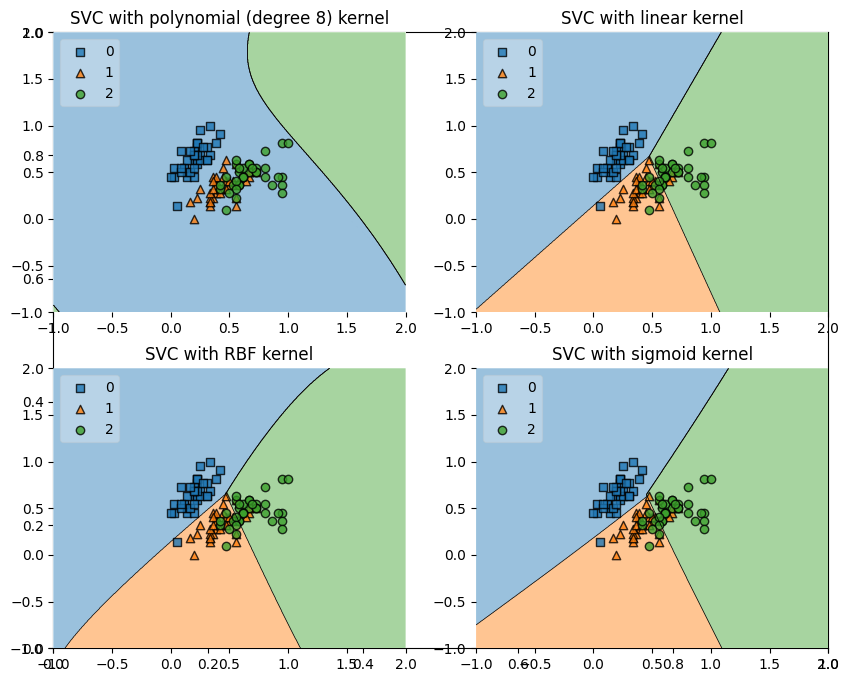

In [243]:
# Different classifiers
clf1 = SVC(kernel = 'poly', degree = 8, gamma = 'auto')
clf2 = SVC(kernel = 'linear', gamma = 'auto')
clf3 = SVC(kernel = 'rbf', gamma = 'auto')
clf4 = SVC(kernel = 'sigmoid', gamma = 'auto')

# Counter variable
count = 1

# Adjustments for the plots
plt.subplots(figsize = (10, 8))
titles = ('SVC with polynomial (degree 8) kernel', 'SVC with linear kernel', 'SVC with RBF kernel', 'SVC with sigmoid kernel')

# Loop
for clf, label in zip([clf1, clf2, clf3, clf4], titles):

    # Fitting classifier
    clf.fit(X_train[:, :2], y_train)
    
    # Plotting results
    plt.subplot(2,2,count)
    fig = plot_decision_regions(X = X_train[:, :2], y = y_train, clf = clf, legend = 2)
    plt.title(label)
    count+=1

plt.show()


We can see that polynomial kernel is completely wrong as it misclassifies all the samples belonging to classes 1 and 2. The others are behaving well.

## **3. Searching the best model**
Once we have explored the behaviour of different kernels, we are interested in searching the best hyperparameters for our support vector classifier.

### **3.1. Performing grid search**
To achieve our goal, we will perform a grid search using cross-validation. We first generate a list of 13 values for each hyperparameter using `logspace()`. Then we define a dictionary `param_grid`, where the keys represent the hyperparameters and the values represent the ranges where to perform the grid search.

In [219]:
# Hyperparameters range
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

# Redefining kernel types
kernels =  ['linear', 'rbf', 'poly', 'sigmoid']

# Grid of parameters
param_grid = dict(gamma = gamma_range, C = C_range, kernel = kernels)

Then we initialize a cross-validator using the `StratifiedShuffleSplit()` function from `sklearn`. In particular, we set the number of splits `n_splits` to five, the test set size `test_size` to be the 20% of the entire training set and seed `random_state` for reproducibility purposes.

In [220]:
# Cross-validator
cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 42)

Finally we define a `grid` object using `GridSearchCV()` function from `sklearn` and then we fit it on the training set in order to perform the grid search.

In [221]:
# Declaring the grid search
grid = GridSearchCV(SVC(probability = True), param_grid = param_grid, cv = cv)

# Fitting the grid search
grid.fit(X_train, y_train)

# Printing results
print('Best C:', grid.best_params_['C'])
print('Best gamma:', grid.best_params_['gamma'])
print('Best score:', grid.best_score_)

Best C: 100000000.0
Best gamma: 1e-06
Best score: 0.9739130434782609


With the hyperparameters found by grid search we can achieve an accuracy of more than 97%!

## **4. Predicting the outcomes**
Let's now predict the outcomes for the test set using the support vector model with the best parameters found by the grid search. As usual, we use the `predict()` function.

In [222]:
# Computing predictions
grid_predictions = grid.predict(X_test)

### **4.1. Confusion matrix**
Then we compute the confusion matrix using the true labels and the predicted labels.

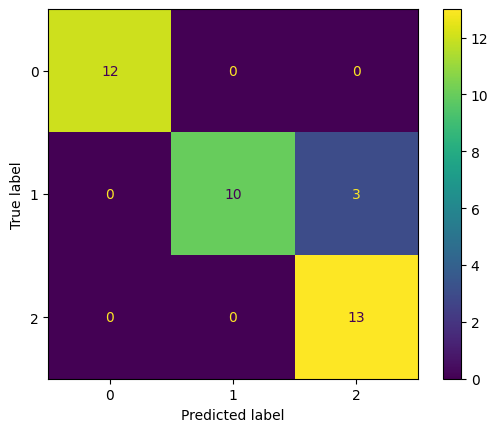

In [236]:
# Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, grid_predictions)

# Plot confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

We can see that the matrix is composed by 3 classes against 3 classes predicted labels. As we can see our best classifier is near to be the best classifier!

### **4.2. ROC curves**
Let's also plot the ROC curves for our multiclass classification problem. We need to compute the predicted class probability for each instance of the independent test set. For this purpose we use the `predict_proba()` function instead of the `predict()` function, because we are only interested in the probability score and not in the final label.

In [224]:
# Computing probabilities
y_score = grid.predict_proba(X_test)

Then we import the function `label_binarize()` from `sklearn` in order to convert the class labels in a binary format that is more suitable for multiclass analysis. 

In [225]:
from sklearn.preprocessing import label_binarize

# Converting labels
y_test1 = label_binarize(y_test, classes = [0, 1, 2])

# Number of classes
n_classes = y_test1.shape[1]

We initialize the false positives rate `fpr`, the true positives rate `tpr` and the ROC AUC score `roc_auc` dictionaries to store for each class the corresponding values.

In [226]:
# Empty dictionaries
fpr = dict()
tpr = dict()
roc_auc = dict()

Finally we iterate over the three classes to plot the ROC curves, the random classifier and the perfect classifier.

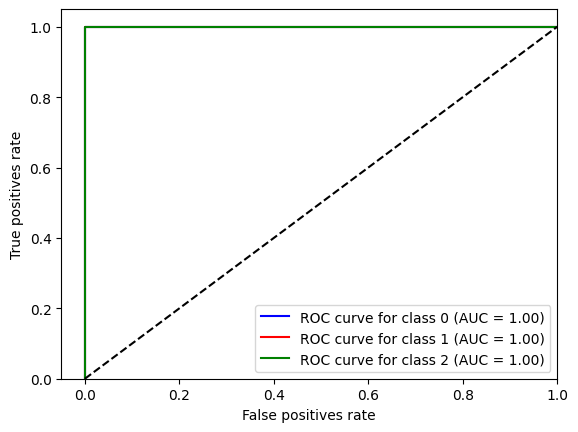

In [227]:
for i in range(n_classes):

    # Computing false positives and true positives rate
    fpr[i], tpr[i], _ = roc_curve(y_test1[:,i], y_score[:,i])

    # Computing ROC AUC score
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color = color, lw = 1.5, label = 'ROC curve for class {0} (AUC = {1:0.2f})'''.format(i, roc_auc[i]))
    
plt.plot([0,1], [0,1], 'k--', lw = 1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positives rate')
plt.ylabel('True positives rate')
plt.legend(loc = 'lower right')
plt.show() 



## **5. Comparing different models**
Now we can ask ourselves is the support vector classifier is among all the best classifier. In order to answer this question we have to compare different models.

### **5.1. Performing cross-validation**
We now perform cross-validation on three different classifiers which are the logistic regression classifier, the gaussian naive bayes classifier and our support vector classifier.

In [228]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

We create an empty list `model` to evaluate the different classifiers. After that, we declare and append the classifiers. Then we set a random seed and we initialize other two empty lists `results` and the `names` which will be useful to store the results of our analysis. We also specify that the score we are interested in is accuracy.

In [229]:
# Empty list
models = []

# Appending classifiers
# models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel = 'rbf')))

# Random seed
seed = 10

# Empty lists
results = []
names = []

# Score
scoring = 'accuracy'

Then we loop over each model in order to compare them. In particular, we declare a k-fold cross-validator with 10 split and with data shuffling enabled. Then we perform the cross-validation on the model and we compute the accuracy score for each fold. Finally we print the results for each model.

In [230]:
for name, model in models:
    
    # Declaring cross-validator
    kfold = model_selection.KFold(n_splits = 10, shuffle = True, random_state = seed)

    # Performing cross-validation
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)

    # Printing results
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

NB: 0.946970 (0.057196)
SVM: 0.957576 (0.077273)


Results are very similar but the support vector machine model seems to be the best.

### **5.2. Understanding results**
We can also compare the differences between the performances of the classifiers using a box plot, in which each box represents the interquantile range on the accuracy score and the lines inside the boxes represent the median value.

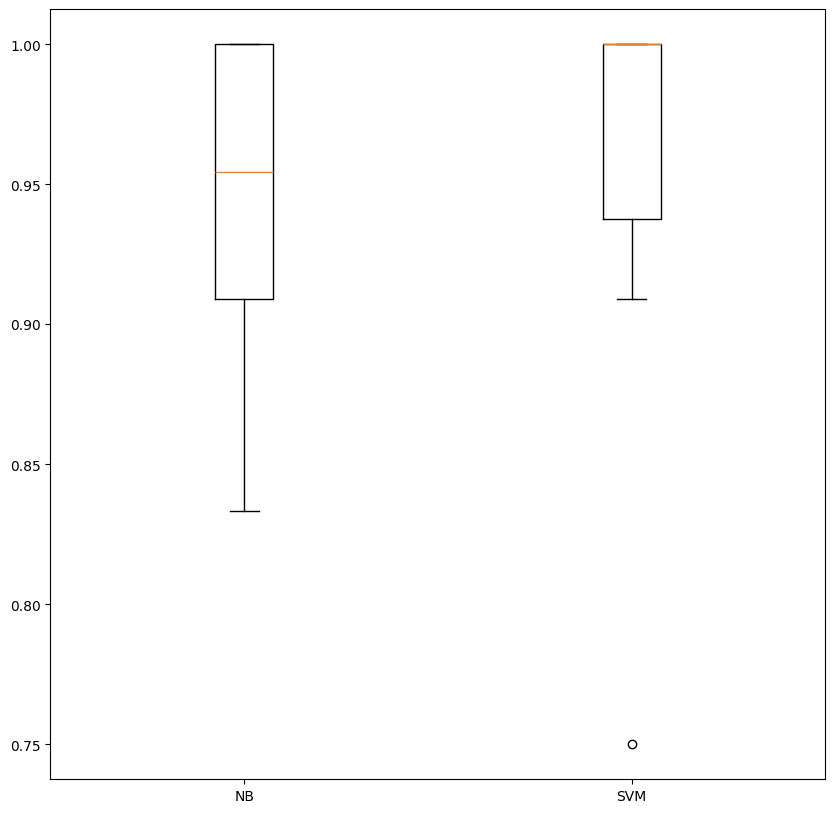

In [231]:
# Box plot
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


### **5.3. Fitting the Gaussian Naive-Bayes model**
Finally, we are interested in fitting the Gaussian Naive-Bayes model on our training data in order to copute the predicted probability scores for each class on the independent test set and evaluate the correlation with the probability scores from our support vector classifier. We initialize the model and fit it on the training test. Then we compute the scores.

In [232]:
# Model declaration
model = GaussianNB()

# Fitting the model
model.fit(X_train, y_train)

# Computing scores
y_score_NB = model.predict_proba(X_test)

Finally we can plot the correlation between the scores of the two models for the class 2. We will consider the `y_score` on the x-axis and the `y_score_NB` on the y-axis.

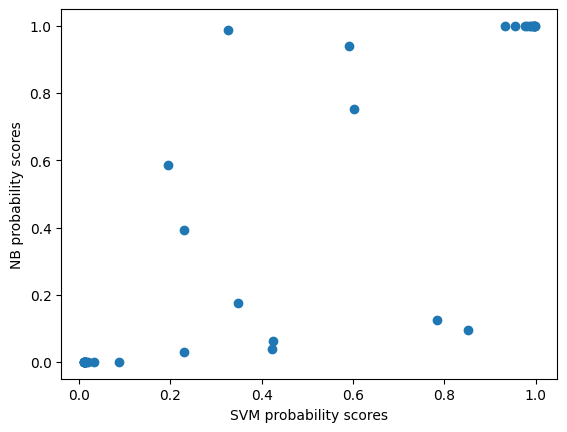

In [233]:
plt.scatter(y_score[:, 2], y_score_NB[:, 2])
plt.xlabel('SVM probability scores')
plt.ylabel('NB probability scores')
plt.show()


We can observe a sort of linear relationship between the probability scores of the two models. Even if the behaviour is quite similar, there are some samples in which the scores achieved by the two classifiers look very dissimilar.
